In [13]:
from selenium import webdriver
from bs4 import BeautifulSoup
import os
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

DATA ACQUISITION FROM CANADA WEATHER DATABASE ACCESSIBLE ONLINE

The database contain CSV records from over 100 weather observation stations accross Ontario.

In [15]:
# Set up the Chrome webdriver
# This opens a new browser window that the script can control
driver = webdriver.Chrome()

# Open the URL of the webpage you want to scrape
url = "https://dd.weather.gc.ca/climate/observations/monthly/csv/ON/"
driver.get(url)

# parse the page source with BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [17]:
# find all 'a' tags with href ending with '.csv'
csv_files = soup.find_all('a', href=lambda x: x and x.endswith('.csv'))

# limit the number of files to download
csv_files = csv_files[:15000]

# create a new directory in the current working directory to save the csv files
path_to_save_files = os.path.join(os.getcwd(), 'ontario_weather_data')
os.makedirs(path_to_save_files, exist_ok=True)

# download each csv file
for file in csv_files:
    file_url = url + file['href']
    response = requests.get(file_url)
    with open(os.path.join(path_to_save_files, file['href']), 'wb') as f:
        f.write(response.content)

# print the number of files successfully downloaded
print(f"Number of CSV files downloaded: {len(os.listdir(path_to_save_files))}")

# close the browser
driver.quit()

Number of CSV files downloaded: 15000


In [27]:
# compile all csv files into one
all_files = [pd.read_csv(os.path.join(path_to_save_files, f)) for f in os.listdir(path_to_save_files) if f.endswith('.csv')]
df = pd.concat(all_files, axis=0, ignore_index=True)

# create a new directory to save the compiled csv file
path_to_save_compiled_file = os.path.join(os.getcwd(), 'ontario_weather_data_compiled')
os.makedirs(path_to_save_compiled_file, exist_ok=True)

# save the compiled dataframe to a csv file
df.to_csv(os.path.join(path_to_save_compiled_file, 'ontario_weather_observation.csv'), index=False)

# print the total number of rows and columns after merging
print(f"Total number of rows after merging: {df.shape[0]}")
print(f"Total number of columns after merging: {df.shape[1]}")


Total number of rows after merging: 160735
Total number of columns after merging: 27


In [29]:
df.head

<bound method NDFrame.head of                Station Name  Longitude  Latitude Climate ID Province  Year  \
0       ALGONQUIN PARK EAST    -78.267    45.533    6080191       ON  1964   
1       ALGONQUIN PARK EAST    -78.267    45.533    6080191       ON  1964   
2       ALGONQUIN PARK EAST    -78.267    45.533    6080191       ON  1964   
3       ALGONQUIN PARK EAST    -78.267    45.533    6080191       ON  1964   
4       ALGONQUIN PARK EAST    -78.267    45.533    6080191       ON  1964   
...                     ...        ...       ...        ...      ...   ...   
160730             GORE BAY    -82.467    45.917    6092915       ON  1942   
160731             GORE BAY    -82.467    45.917    6092915       ON  1942   
160732             GORE BAY    -82.467    45.917    6092915       ON  1942   
160733             GORE BAY    -82.467    45.917    6092915       ON  1942   
160734             GORE BAY    -82.467    45.917    6092915       ON  1942   

       Month    Tm  DwTm   D  ...

PRE PROCESSING, DATA CLEANING, AND EXPLORATORY DATA ANALYSIS

Below visualizations show the state of the dataset before cleaning.
I will show visualizations for before and after cleaning of the dataset.

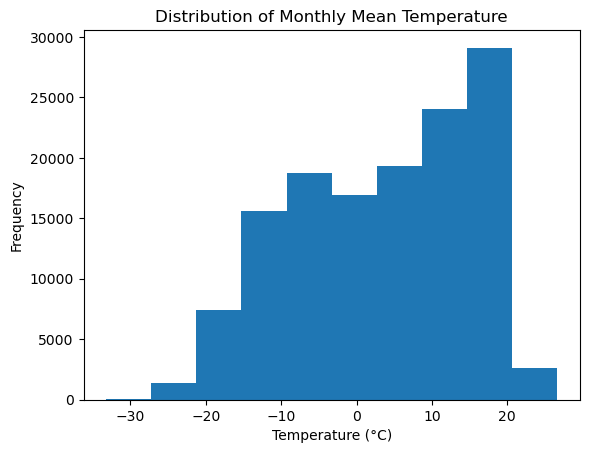

In [31]:
# Histogram for 'Tm' (Monthly mean temperature)
plt.hist(df['Tm'])
plt.title('Distribution of Monthly Mean Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

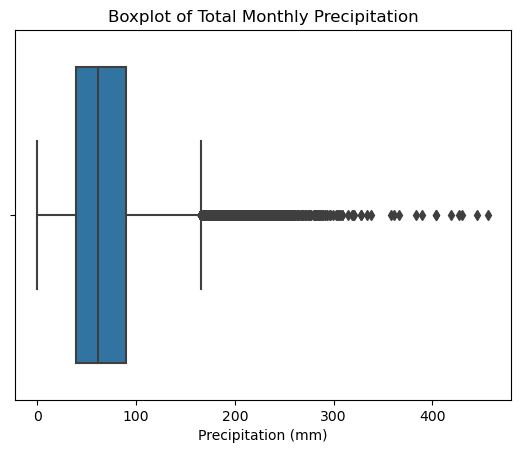

In [33]:
# Boxplot for 'P' (Total Precipitation Monthly)
sns.boxplot(x=df['P'])
plt.title('Boxplot of Total Monthly Precipitation')
plt.xlabel('Precipitation (mm)')
plt.show()

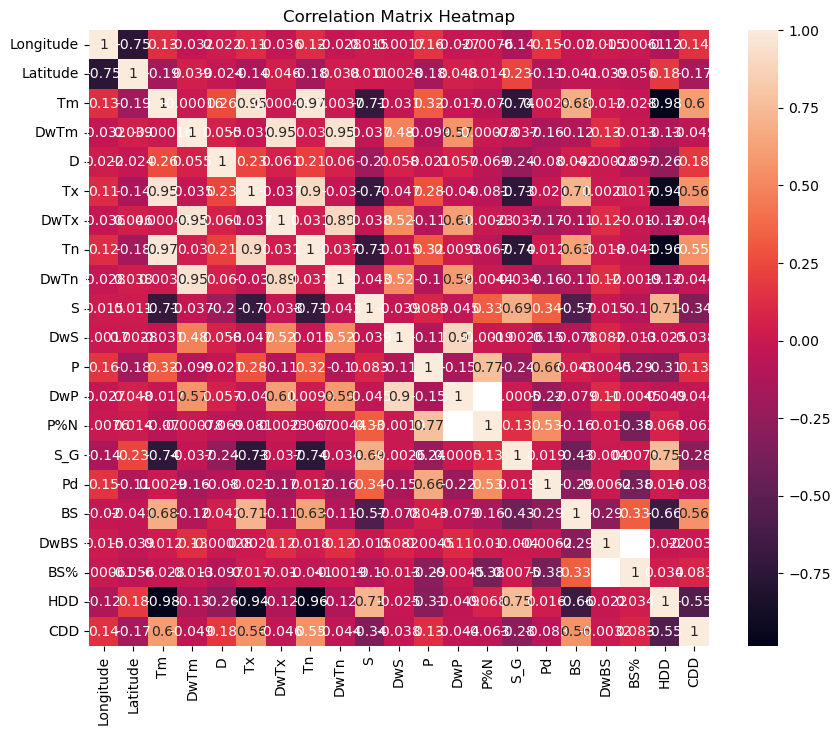

In [35]:
# Heatmap for correlation matrix
# Select only numerical columns
numerical_cols = df.select_dtypes(include=[np.number])

# Compute correlation matrix for numerical columns only
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_cols.corr(), annot=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

HANDLING MISSING VALUES

In [37]:
# Check for missing values in all columns
print(df.isnull().sum())

Station Name         0
Longitude            0
Latitude             0
Climate ID           0
Province             0
Year                 0
Month                0
Tm               25551
DwTm             25551
D               120853
Tx               25003
DwTx             25003
Tn               25099
DwTn             25099
S                19157
DwS              19157
S%N             132519
P                 6074
DwP               6074
P%N             121593
S_G             120303
Pd                6074
BS              151176
DwBS            151176
BS%             156312
HDD              25551
CDD              25551
dtype: int64


In [39]:
# Forward fill for continuous variables like temperature
for column in ['Tm', 'Tx', 'Tn']:
    df[column].fillna(method='ffill', inplace=True)

# Fill with 0 for count or total variables
for column in ['DwTm', 'D', 'DwTx', 'DwTn', 'S', 'DwS', 'P', 'DwP', 'S_G', 'Pd', 'BS', 'DwBS', 'HDD', 'CDD']:
    df[column].fillna(0, inplace=True)

# For percentage variables, we can assume if it's NaN the percentage is 0
for column in ['S%N', 'P%N', 'BS%']:
    df[column].fillna(0, inplace=True)

In [41]:
print(df.isnull().sum())

Station Name    0
Longitude       0
Latitude        0
Climate ID      0
Province        0
Year            0
Month           0
Tm              0
DwTm            0
D               0
Tx              0
DwTx            0
Tn              0
DwTn            0
S               0
DwS             0
S%N             0
P               0
DwP             0
P%N             0
S_G             0
Pd              0
BS              0
DwBS            0
BS%             0
HDD             0
CDD             0
dtype: int64


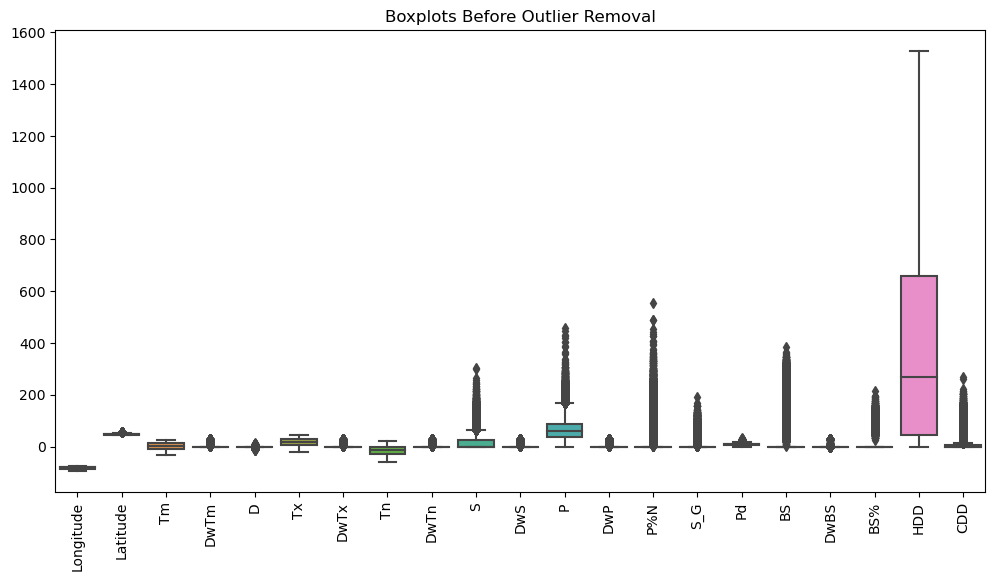

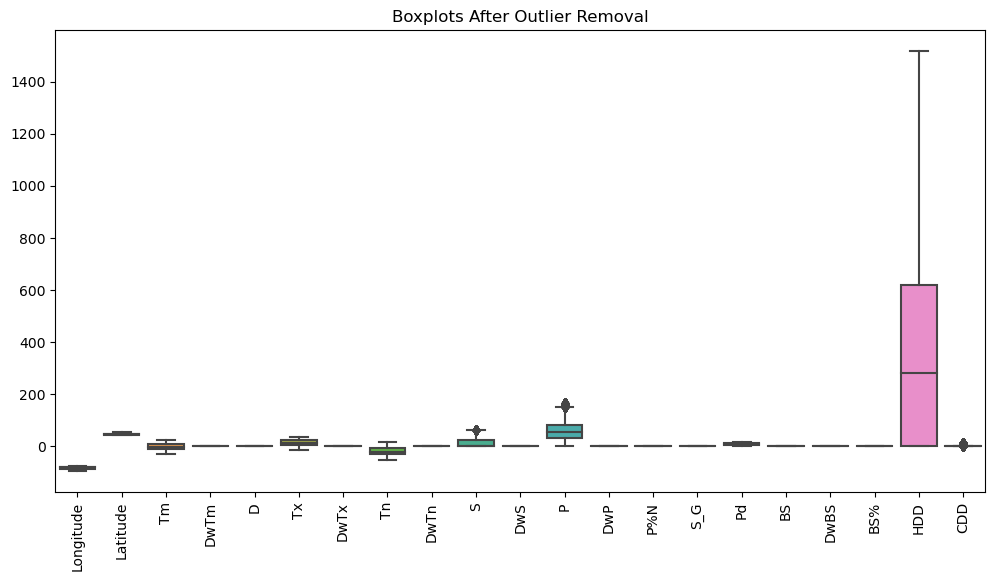

In [44]:
# Select only numerical columns
numerical_cols = df.select_dtypes(include=[np.number])

# Using IQR score for outlier detection
Q1 = numerical_cols.quantile(0.25)
Q3 = numerical_cols.quantile(0.75)
IQR = Q3 - Q1

# Define a function for plotting boxplots
def plot_boxplots(data, title):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

# Plot boxplots before outlier removal
plot_boxplots(numerical_cols, 'Boxplots Before Outlier Removal')

# Removing outliers
df_outliers_removed = df[~((numerical_cols < (Q1 - 1.5 * IQR)) | (numerical_cols > (Q3 + 1.5 * IQR))).any(axis=1)]

# Select numerical columns from the DataFrame with outliers removed
numerical_cols_outliers_removed = df_outliers_removed.select_dtypes(include=[np.number])

# Plot boxplots after outlier removal
plot_boxplots(numerical_cols_outliers_removed, 'Boxplots After Outlier Removal')

In [49]:
# Select only numerical columns
numerical_cols = df.select_dtypes(include=[np.number])

# Apply MinMaxScaler to numerical columns
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(numerical_cols), columns=numerical_cols.columns)


In [52]:
# One-hot encoding
df_encoded = pd.get_dummies(df)

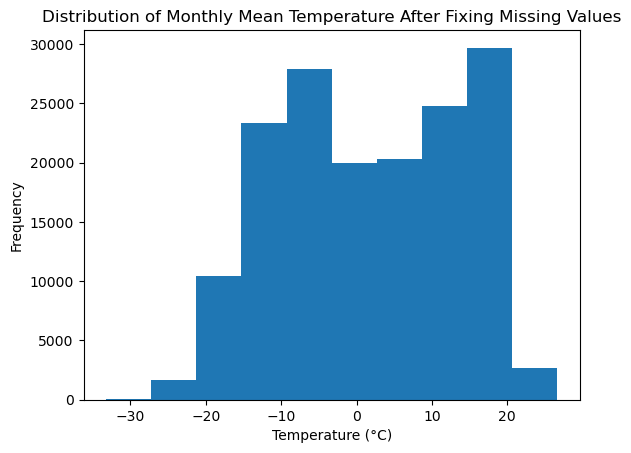

In [60]:
# Histogram for 'Tm' (Monthly mean temperature)
plt.hist(df['Tm'])
plt.title('Distribution of Monthly Mean Temperature After Fixing Missing Values')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

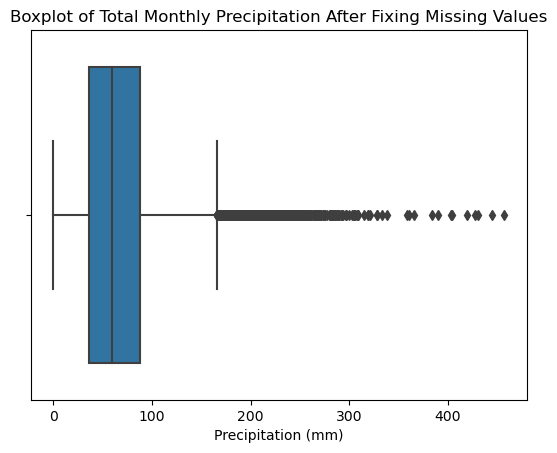

In [62]:
# Boxplot for 'P' (Total Precipitation Monthly)
sns.boxplot(x=df['P'])
plt.title('Boxplot of Total Monthly Precipitation After Fixing Missing Values')
plt.xlabel('Precipitation (mm)')
plt.show()

In [65]:
df.shape

(160735, 27)

In [70]:
# Descriptive statistics
print(df.describe())

           Longitude       Latitude             Tm           DwTm  \
count  160735.000000  160735.000000  160735.000000  160735.000000   
mean      -82.416273      47.172402       1.826735       0.632308   
std         5.729419       2.255798      11.934338       2.662205   
min       -95.150000      44.050000     -33.200000       0.000000   
25%       -86.931000      45.317000      -8.300000       0.000000   
50%       -80.798000      46.483000       1.700000       0.000000   
75%       -77.617000      48.783000      13.000000       0.000000   
max       -74.467000      56.019000      26.600000      30.000000   

                   D             Tx           DwTx             Tn  \
count  160735.000000  160735.000000  160735.000000  160735.000000   
mean       -0.066569      17.149122       0.529735     -14.888214   
std         1.153805      11.314309       2.405386      15.206142   
min       -12.900000     -21.000000       0.000000     -58.300000   
25%         0.000000       6.7000

FEATURE ENGINEERING



In [76]:
# Temporal Features
df['Season'] = df['Month'].map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})


In [94]:
# Climate Zone Features
df['Climate_Zone'] = pd.cut(df['Latitude'], bins=[-90, -66, -23, 23, 66, 90], labels=['Antarctic Zone', 'Southern Temperate Zone', 'Tropical Zone', 'Northern Temperate Zone', 'Arctic Zone'])

In [96]:
# Interaction Features
df['Temp_Range'] = df['Tx'] - df['Tn']

In [98]:
# Aggregation Features
df_yearly = df.groupby(['Station Name', 'Year']).agg({'Tm': 'mean', 'P': 'sum'}).reset_index()

In [100]:
# Missing Value Indicator Features
for col in df.columns:
    df[col + '_IsMissing'] = df[col].isnull()

In [102]:
# Encoding Categorical Variables
df_encoded = pd.get_dummies(df, columns=['Station Name', 'Province'])


In [104]:
# Binning
df['Tm_Binned'] = pd.cut(df['Tm'], bins=[-np.inf, -10, 0, 10, 20, np.inf], labels=['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot'])

In [110]:
# Create 'ExtremeWeather' column
df['ExtremeWeather'] = np.where((df['Tm'] < -10) | (df['Tm'] > 30) | (df['P'] > 50), 1, 0)

In [112]:
df.shape

(160735, 62)

In [114]:
df.head

<bound method NDFrame.head of                Station Name  Longitude  Latitude Climate ID Province  Year  \
0       ALGONQUIN PARK EAST    -78.267    45.533    6080191       ON  1964   
1       ALGONQUIN PARK EAST    -78.267    45.533    6080191       ON  1964   
2       ALGONQUIN PARK EAST    -78.267    45.533    6080191       ON  1964   
3       ALGONQUIN PARK EAST    -78.267    45.533    6080191       ON  1964   
4       ALGONQUIN PARK EAST    -78.267    45.533    6080191       ON  1964   
...                     ...        ...       ...        ...      ...   ...   
160730             GORE BAY    -82.467    45.917    6092915       ON  1942   
160731             GORE BAY    -82.467    45.917    6092915       ON  1942   
160732             GORE BAY    -82.467    45.917    6092915       ON  1942   
160733             GORE BAY    -82.467    45.917    6092915       ON  1942   
160734             GORE BAY    -82.467    45.917    6092915       ON  1942   

       Month    Tm  DwTm    D  ..

MODEL SELECTION, TRAINING, AND EVALUATION


Random Forest Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9177
           1       1.00      1.00      1.00     22970

    accuracy                           1.00     32147
   macro avg       1.00      1.00      1.00     32147
weighted avg       1.00      1.00      1.00     32147

Random Forest ROC AUC Score: 1.0


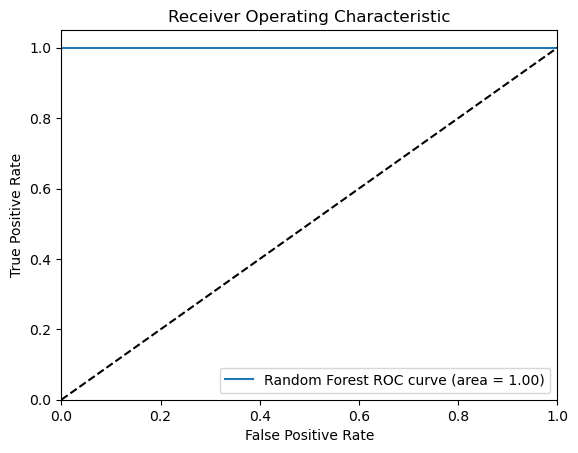

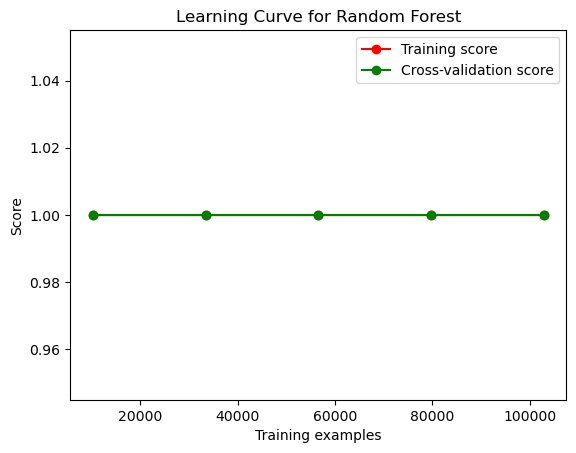

Random Forest Confusion Matrix:
[[ 9177     0]
 [    0 22970]]


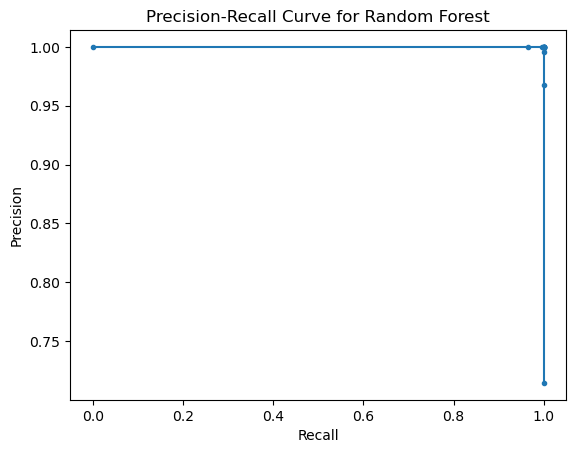

SVM Best Parameters: {'C': 10, 'gamma': 1}
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9177
           1       1.00      1.00      1.00     22970

    accuracy                           1.00     32147
   macro avg       1.00      0.99      1.00     32147
weighted avg       1.00      1.00      1.00     32147

SVM ROC AUC Score: 0.9999232621881406


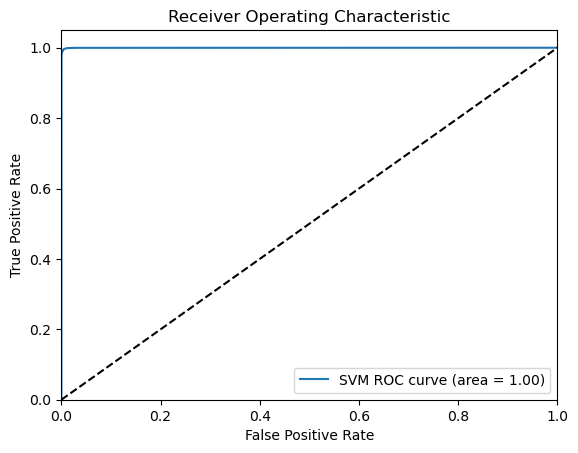

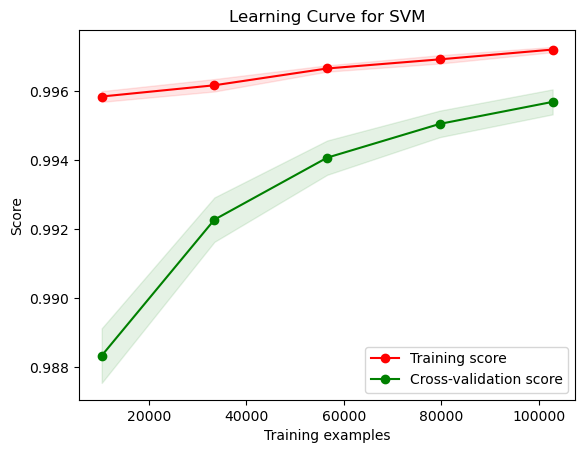

SVM Confusion Matrix:
[[ 9105    72]
 [   58 22912]]


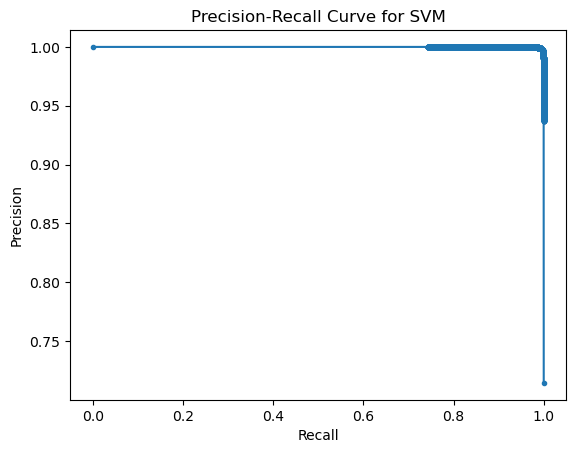

Logistic Regression Best Parameters: {'C': 10}
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      9177
           1       0.92      0.94      0.93     22970

    accuracy                           0.90     32147
   macro avg       0.88      0.87      0.87     32147
weighted avg       0.90      0.90      0.90     32147

Logistic Regression ROC AUC Score: 0.9621518494993897


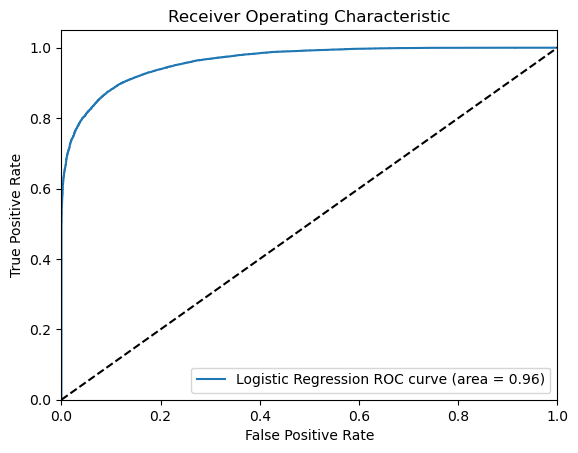

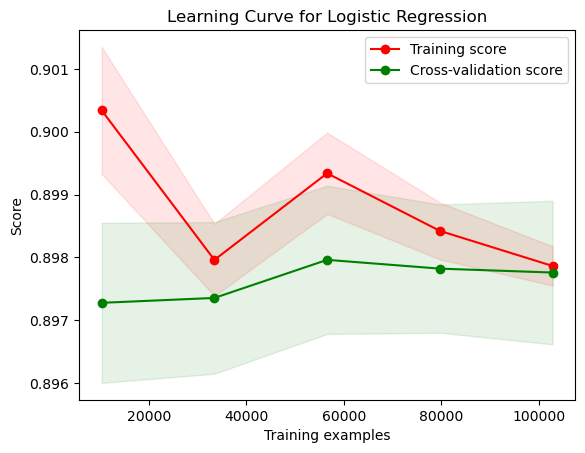

Logistic Regression Confusion Matrix:
[[ 7319  1858]
 [ 1376 21594]]


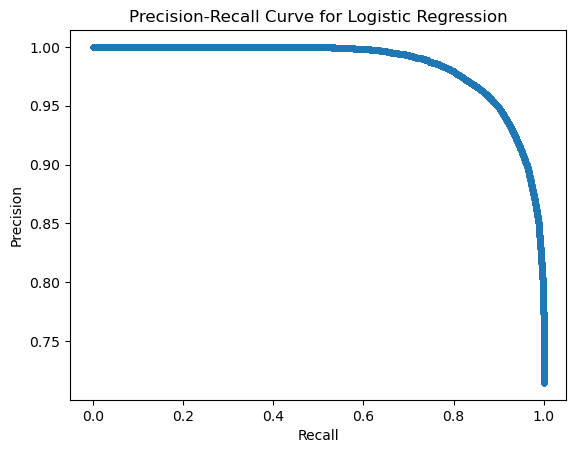

In [117]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Define the feature columns and the target column
feature_cols = ['Tm', 'Tx', 'Tn', 'P', 'S', 'HDD', 'CDD']  # Add or remove features as needed
target_col = 'ExtremeWeather'

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df[target_col], test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the models and their respective hyperparameters for GridSearchCV
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]}
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {'C': [0.1, 1, 10]}
    }
}

for name, model in models.items():
    # Hyperparameter Tuning
    grid_search = GridSearchCV(model['model'], model['params'], cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    # Print best parameters
    print(f"{name} Best Parameters: {grid_search.best_params_}")

    # Retrain model with best parameters
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Model Evaluation
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{name} ROC AUC Score: {roc_auc_score(y_test, y_pred_proba)}")
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Generate learning curve
    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5)
    
    # Calculate mean and standard deviation for train and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title(f'Learning Curve for {name}')
    plt.show()

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name} Confusion Matrix:")
    print(cm)

    # Generate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    
    # Plot precision-recall curve
    plt.figure()
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {name}')
    plt.show()
